In [1]:
# Import necessary libraries
import sys
sys.path.insert(0, "..\\..\\")  # add the parent directory to path
import os
import numpy as np
import pandas as pd
import random
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import librosa
import librosa.display
from sklearn.svm import OneClassSVM
from sklearn import metrics
import plotly.express as px
import pickle
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

from utils.get_mel_spectrogram import get_mel_spectrogram
from utils.get_melspec_features_from_files import get_melspec_features_from_files
from utils.confusion_metrics import confusion_metrics
from utils.train_test_one_class_svm import train_test_one_class_svm
from utils.get_train_test_data import get_train_test_data
from utils.add_train_test_labels_to_dataframe import add_train_test_labels_to_dataframe

In [2]:
# Directories
parent_dir = os.path.abspath('..\\..\\..\\')  # main directory
# Audio data directory
data_dir = os.path.join(parent_dir, 'Data', 'Source')  # audio data directory
# Features directory
features_dir = os.path.join(parent_dir, 'Data', 'Features')  # audio data directory
# Metada directory
metadata_dir = os.path.join(parent_dir, 'Data', 'Metadata')  # metadata directory
# Images directory
images_dir = os.path.join(parent_dir, 'Images')  # images directory

In [3]:
# Load extracted features
machine_type = 'fan'

window = 1
n_mels = 32
overlap = 0.5
feature_type = 'mel_spect_db'
    
# Export the metadata and extracted features DataFrames to csv files
file_name = f"metadata_{machine_type}_all_samples.csv"
df_machine = pd.read_csv(os.path.join(features_dir, file_name), header=0, index_col=0)

file_name = f"features_{machine_type}_{feature_type}_window_{window:.3f}_overlap_ratio_{overlap:.2f}_no_mel_bands_{n_mels:d}.csv"
Xy = pd.read_csv(os.path.join(features_dir, file_name), header=0, index_col=0)

# Load params 
file_name = f"params_{machine_type}_{feature_type}_window_{window:.3f}_overlap_ratio_{overlap:.2f}_no_mel_bands_{n_mels:d}.json"
with open(os.path.join(features_dir, file_name)) as json_file:
    params = json.load(json_file)

In [4]:
# Choose samples from a single model
n_model = 4
df_machine = df_machine[df_machine.model==n_model]
Xy = Xy.loc[df_machine.index] 

In [5]:
df_machine

,file_no,machine,model,anomaly,file_name,file_rel_path,duration_s,fs_Hz,SNR_dB
2793,2793,fan,4,1,00000000.wav,6_dB_fan\fan\id_04\abnormal\00000000.wav,10.0,16000,6
2794,2794,fan,4,1,00000001.wav,6_dB_fan\fan\id_04\abnormal\00000001.wav,10.0,16000,6
2795,2795,fan,4,1,00000002.wav,6_dB_fan\fan\id_04\abnormal\00000002.wav,10.0,16000,6
2796,2796,fan,4,1,00000003.wav,6_dB_fan\fan\id_04\abnormal\00000003.wav,10.0,16000,6
2797,2797,fan,4,1,00000004.wav,6_dB_fan\fan\id_04\abnormal\00000004.wav,10.0,16000,6
...,...,...,...,...,...,...,...,...,...
4169,4169,fan,4,0,00001028.wav,6_dB_fan\fan\id_04\normal\00001028.wav,10.0,16000,6
4170,4170,fan,4,0,00001029.wav,6_dB_fan\fan\id_04\normal\00001029.wav,10.0,16000,6
4171,4171,fan,4,0,00001030.wav,6_dB_fan\fan\id_04\normal\00001030.wav,10.0,16000,6
4172,4172,fan,4,0,00001031.wav,6_dB_fan\fan\id_04\normal\00001031.wav,10.0,16000,6


In [6]:
Xy

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,31_12,31_13,31_14,31_15,31_16,31_17,31_18,31_19,31_20,anomaly
2793,5.893141,6.532468,7.154486,7.433260,7.280755,9.085330,6.708955,7.095646,6.825620,6.731694,...,-24.230547,-24.091852,-23.997295,-23.622295,-24.122490,-24.023266,-24.422112,-23.957235,-23.747065,1
2794,5.299906,6.402521,7.124662,7.247043,6.640387,6.117057,4.655535,6.938139,6.190164,6.334588,...,-21.894464,-21.967438,-21.801292,-22.108036,-22.245815,-22.001116,-22.128922,-22.068636,-22.370182,1
2795,7.041318,6.424939,6.589318,5.657062,5.993620,7.694964,6.707364,6.611197,5.175795,6.519910,...,-21.007671,-20.713062,-21.448140,-20.846370,-21.077301,-21.190971,-21.179825,-21.372034,-21.233060,1
2796,7.278595,5.150165,6.579251,6.119970,6.907925,7.505195,7.042795,7.704929,6.199623,7.133968,...,-22.103941,-21.984001,-22.322952,-22.394953,-22.302732,-22.222000,-22.224361,-22.185076,-22.500074,1
2797,6.673363,7.461422,7.223129,5.427374,6.735353,7.892208,7.678797,6.594194,7.791991,6.302674,...,-23.442654,-23.385708,-23.606500,-23.217209,-23.551370,-23.781784,-23.752712,-22.948761,-23.473932,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4169,-0.422778,2.005244,0.533487,2.144211,0.655738,6.258197,2.646015,2.294885,-2.320638,3.857560,...,-19.667507,-19.890818,-20.007952,-19.974285,-20.108128,-20.310572,-20.056364,-20.503237,-19.995325,0
4170,1.281557,0.270751,-2.664982,0.375039,3.566570,1.392226,2.091284,3.361535,3.302519,5.655176,...,-19.131855,-18.778060,-18.859722,-18.764952,-18.713596,-19.196280,-19.141716,-18.583170,-19.055643,0
4171,0.919836,1.240931,0.968471,1.139285,0.638258,1.261350,0.755678,0.749955,1.912669,1.742465,...,-19.512709,-19.568810,-19.056719,-19.450653,-19.493858,-19.197561,-19.414957,-19.581284,-19.329746,0
4172,0.515286,-0.366056,2.248169,1.885337,3.060303,-0.339084,1.350713,2.696954,0.108913,3.281188,...,-20.037260,-19.954805,-19.811172,-19.792126,-19.677134,-19.652306,-19.793472,-19.940400,-20.152447,0


In [7]:
# Randomly separate a subset of samples as the final test samples
df_machine_all = df_machine.copy()

df_machine = df_machine.groupby(["anomaly"]).sample(frac=0.8, random_state=13)
df_machine_test = df_machine_all.drop(df_machine.index)

Xy_all = Xy.copy()
Xy = Xy.loc[df_machine.index]
Xy_test = Xy_all.loc[df_machine_test.index]

In [8]:
df_machine = df_machine.reset_index(inplace=False, drop=False)
df_machine_test = df_machine_test.reset_index(inplace=False, drop=False)
Xy = Xy.reset_index(inplace=False, drop=False)
Xy_test = Xy_test.reset_index(inplace=False, drop=False)

df_machine.groupby(["model", "anomaly"])['file_name'].count().reset_index(name='count')

,model,anomaly,count
0,4,0,826
1,4,1,278


In [9]:
X = Xy.iloc[:, :-1]
X = X.copy()
X

,index,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,31_11,31_12,31_13,31_14,31_15,31_16,31_17,31_18,31_19,31_20
0,3336,4.544082,3.913166,0.500588,2.592858,4.625675,1.331684,2.224935,2.032204,3.411654,...,-20.245739,-20.311977,-20.142967,-20.173473,-20.597200,-20.617657,-20.488588,-20.108002,-20.648520,-20.209887
1,3694,-0.362874,1.667706,2.359125,0.876033,0.147653,0.353382,1.397799,1.216687,3.004662,...,-20.671768,-20.453712,-20.318714,-20.042023,-20.659721,-20.518084,-20.643124,-20.946863,-20.873320,-20.345196
2,4048,4.092711,2.123566,0.339539,-1.533203,1.156034,-0.096567,0.492232,-0.003622,2.174760,...,-19.351728,-19.282652,-19.265707,-19.120602,-19.465721,-19.294472,-19.044376,-19.474491,-19.469730,-19.366074
3,4082,1.847946,-0.604450,0.763788,-0.983098,0.166814,1.291625,1.095222,2.160469,-0.664053,...,-19.372470,-19.431290,-19.418930,-19.583908,-19.504500,-19.790754,-19.645680,-19.586750,-18.998690,-19.188541
4,3418,4.756654,7.418285,1.221451,3.385019,3.790725,3.522892,2.020577,3.497362,2.253046,...,-20.374123,-20.716354,-20.453007,-20.324060,-20.560177,-20.258228,-20.334217,-20.512077,-20.359058,-20.204662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099,2931,1.755806,3.142121,3.481917,1.921656,2.475657,3.502317,1.666485,2.614984,2.732493,...,-17.901443,-17.846983,-17.937336,-18.203238,-18.043104,-18.391716,-18.275902,-18.180502,-18.216898,-18.310970
1100,2909,-1.030491,-0.331332,-0.733312,-0.626748,-1.372067,-1.474006,-1.137059,-0.818931,-0.616455,...,-17.234093,-17.313587,-17.889963,-18.080158,-17.543371,-17.505701,-17.793274,-17.596373,-17.892832,-17.564678
1101,3027,4.080366,5.740977,6.050788,6.623933,6.492522,3.674432,5.646964,10.735150,4.870344,...,-18.616749,-18.806686,-18.647617,-18.773033,-18.780554,-18.782087,-18.605492,-18.819456,-18.577888,-18.640882
1102,3014,4.423748,3.523269,4.315843,4.826946,3.281105,2.966599,3.465776,3.479708,3.399226,...,-18.396320,-18.009764,-18.171848,-17.922730,-18.006870,-17.967701,-18.605550,-18.310590,-18.410630,-18.711073


In [10]:
y = Xy.iloc[:, -1]
y = pd.DataFrame(y.copy())
y

,anomaly
0,0
1,0
2,0
3,0
4,0
...,...
1099,1
1100,1
1101,1
1102,1


In [11]:
# Feature normalization
minval = X.min()
maxval = X.max()
X = (X-minval)/(maxval-minval)

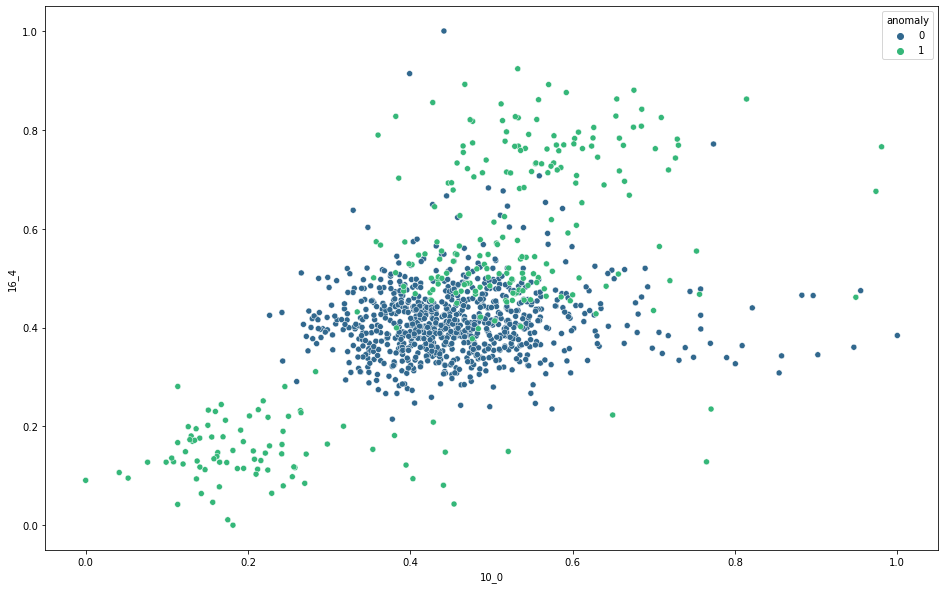

In [12]:
# Scatter plot for model and anomaly with true labels
plot_columns = {'x': '10_0',
                'y': '16_4'}
df_toplot = X.copy()
df_toplot = df_toplot.join(y)
df_toplot = df_toplot.join(df_machine.model)
ind_x = list(df_toplot.columns.values).index(plot_columns['x'])
ind_y = list(df_toplot.columns.values).index(plot_columns['y'])

plt.figure(figsize=(16,10))
s = sns.scatterplot(x=plot_columns['x'], y=plot_columns['y'], data=df_toplot,
                    hue='anomaly',
                   palette='viridis')
plt.show()

In [13]:
# Elbow method for clusters
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 15)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

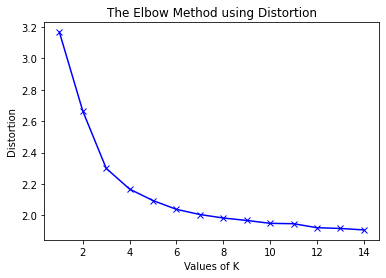

In [14]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [15]:
# fit a kmeans object to the dataset
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++').fit(X)

# clusters is an attribute of the object
cluster_centers = kmeans.cluster_centers_

# add cluster index to dataframe
cluster_labels = pd.Series(kmeans.labels_, name='cluster')
try:
    df_machine = df_machine.join(cluster_labels)
except:
    df_machine['cluster'] = cluster_labels

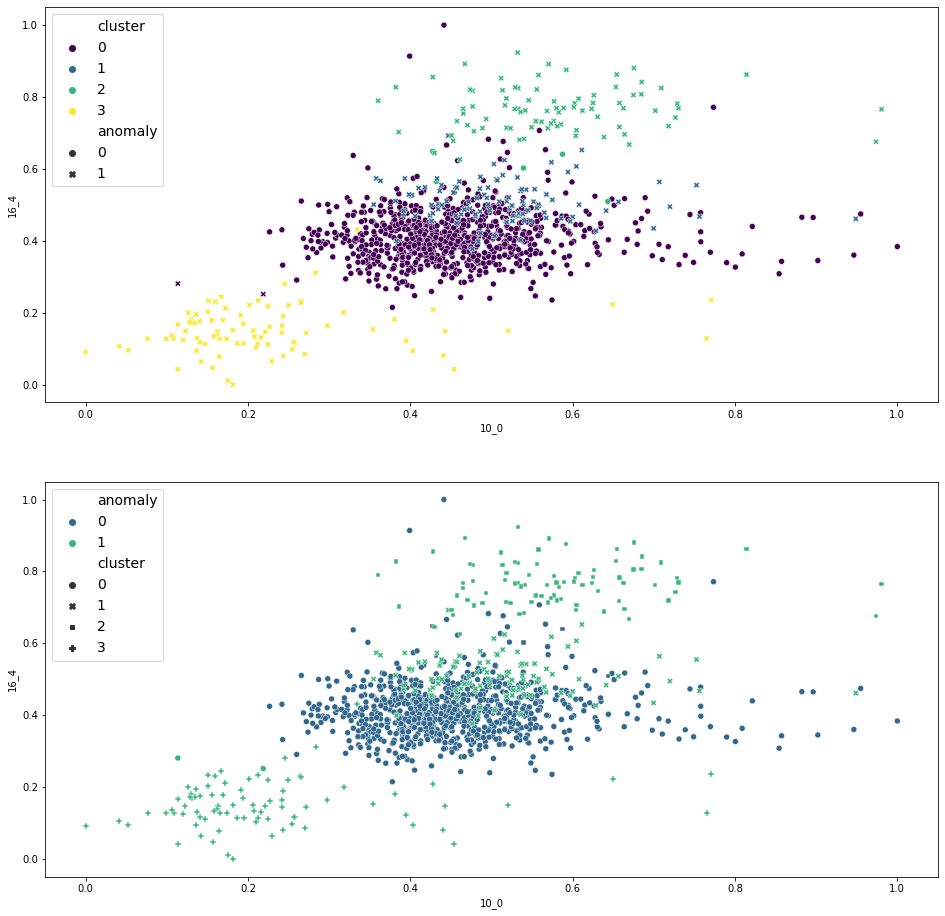

In [16]:
# Scatter plot for model and anomaly with true labels
plot_columns = {'x': '10_0',
                'y': '16_4'}
df_toplot = X.copy()
df_toplot = df_toplot.join(y)
df_toplot = df_toplot.join(df_machine.model)
df_toplot = df_toplot.join(df_machine.cluster)
ind_x = list(df_toplot.columns.values).index(plot_columns['x'])
ind_y = list(df_toplot.columns.values).index(plot_columns['y'])

fig, axs = plt.subplots(2, 1, figsize=(16,16))
s = sns.scatterplot(x=plot_columns['x'], y=plot_columns['y'], data=df_toplot,
                    hue='cluster', style='anomaly',
                    palette='viridis',
                    ax=axs[0])
s.legend(fontsize=14)
s = sns.scatterplot(x=plot_columns['x'], y=plot_columns['y'], data=df_toplot,
                    hue='anomaly', style='cluster',
                    palette='viridis',
                    ax=axs[1])
s.legend(fontsize=14)
plt.show()
file_name = f"fan_model_{n_model}_{n_clusters}_clusters.png"
fig.savefig(os.path.join(images_dir, file_name))

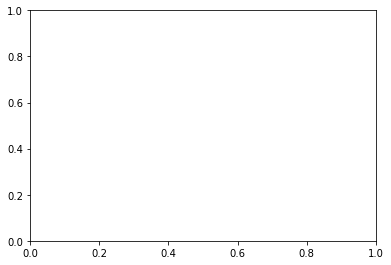

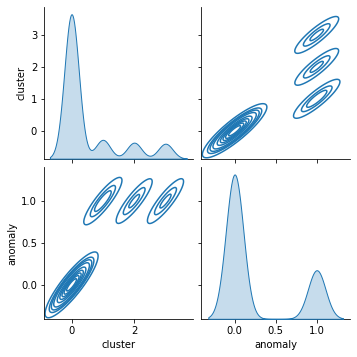

In [17]:
fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
s = sns.pairplot(data=df_machine[['cluster','anomaly']],
                   palette='viridis', kind="kde")
file_name = f"fan_model_{n_model}_{n_clusters}_clusters_pairplot.png"
plt.savefig(os.path.join(images_dir, file_name))

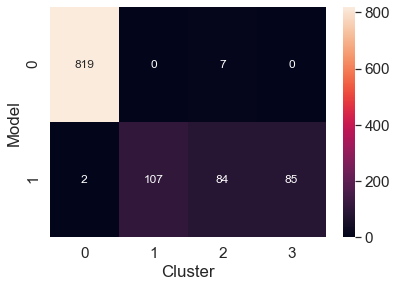

In [20]:
# How good is clustering for model?
cm_clusters = np.zeros((df_machine.anomaly.nunique(), df_machine.cluster.nunique()))
for ind_model, model in enumerate(sorted(df_machine.anomaly.unique())):
    for ind_cluster, cluster in enumerate(sorted(df_machine.cluster.unique())):
        cm_clusters[ind_model, ind_cluster] = np.logical_and(df_machine.anomaly.values==model, df_machine.cluster.values==cluster).sum()    
cm_clusters = cm_clusters.astype('int')

out_metrics_clusters = confusion_metrics(cm_clusters)

cm_plot = cm_clusters
df_cm = pd.DataFrame(cm_plot, range(cm_plot.shape[0]), range(cm_plot.shape[1]))

fig = plt.figure()
ax = fig.add_axes([0.1,0.1,0.8,0.8])
sns.set(font_scale=1.4)
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='d', 
                xticklabels=sorted(df_machine.cluster.unique()),
                yticklabels=sorted(df_machine.anomaly.unique()),
                ax=ax)
plt.xlabel('Cluster')
plt.ylabel('Model')
plt.show()

file_name = f"fan_model_{n_model}_anomaly_cluster_{n_clusters}_clusters_confusion_matrix.png"
fig.savefig(os.path.join(images_dir, file_name))

In [19]:
# How similar are those clusters
